In [1]:
# !pip install speechbrain==1.0.0
# !pip install torch torchaudio

In [2]:
# !pip install librosa 

In [177]:
from pathlib import Path 
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import torchaudio
import librosa
import librosa.display

## Inspect training data 

In [4]:
cats = ["dehumidifier", "gas_boiler", "lesker_system"]
files = []
for cls in cats:
    files += glob.glob(f"../data/{cls}/*.wav")

In [5]:
len(files)

44

In [6]:
files[:3]

['../data/dehumidifier/1000060-11-0-0.wav',
 '../data/dehumidifier/1000024-11-0-0.wav',
 '../data/dehumidifier/1000485-11-0-0.wav']

In [9]:
df = pd.DataFrame(dict(filepath=files))
df["label"] = df.filepath.apply(lambda x: Path(x).parent.name)
df["duration"] = df.filepath.apply(lambda x: librosa.get_duration(path=x))
df.sample(5)

,filepath,label,duration
4,../data/dehumidifier/1000000-11-0-0.wav,dehumidifier,4.0
39,../data/lesker_system/2000000-10-0-0.wav,lesker_system,4.0
36,../data/lesker_system/2000264-10-0-0.wav,lesker_system,4.0
10,../data/dehumidifier/1000264-11-0-0.wav,dehumidifier,4.0
9,../data/dehumidifier/1000493-11-0-0.wav,dehumidifier,4.0


In [12]:
# confirm constant duration files (4 secs)
df.duration.value_counts()

duration
4.0    44
Name: count, dtype: int64

In [13]:
sample = df.sample().iloc[0]; sample

filepath    ../data/dehumidifier/1000312-11-0-0.wav
label                                  dehumidifier
duration                                        4.0
Name: 11, dtype: object

In [14]:
display.Audio(sample.filepath, autoplay=True)

In [15]:
df.label.value_counts()

label
dehumidifier     19
lesker_system    15
gas_boiler       10
Name: count, dtype: int64

In [16]:
def get_sample_of(cls: str, random_state=None):
    return df[df.label == cls].sample(random_state=random_state).iloc[0]
    
def play_sample(sample):
    print(sample.filepath, sample.label)
    return display.Audio(sample.filepath, autoplay=True)

def play_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return play_sample(sample)

In [17]:
def plot_spectrogram(filepath, title=None):
    y, sr = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram ({title})')
    plt.tight_layout()
    plt.show()

def show_sample(sample, **kwargs):
    plot_spectrogram(sample.filepath, **kwargs)

def show_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return show_sample(sample)

In [18]:
samp = get_sample_of("dehumidifier")
play_sample(samp)

../data/dehumidifier/1000264-11-0-0.wav dehumidifier


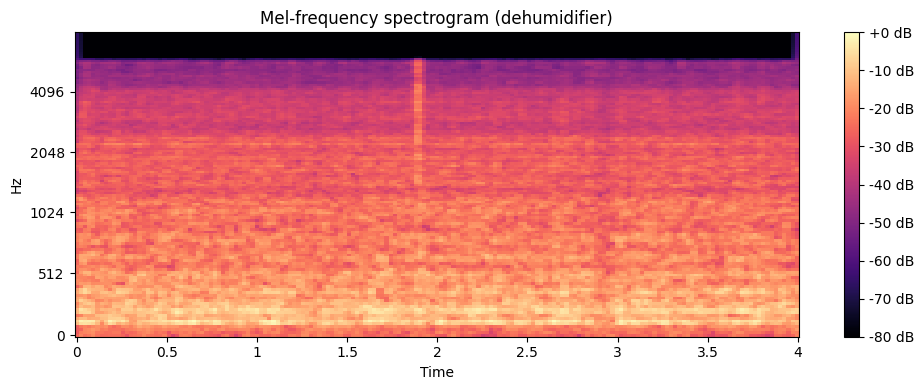

In [19]:
show_sample(samp, title="dehumidifier")

In [20]:
samp = get_sample_of("lesker_system")
play_sample(samp)

../data/lesker_system/2000144-10-0-0.wav lesker_system


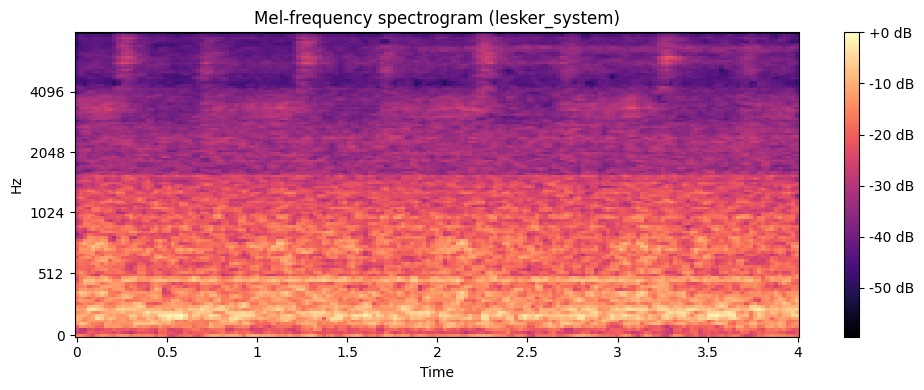

In [21]:
show_sample(samp, title="lesker_system")

In [22]:
samp = get_sample_of("gas_boiler")
play_sample(samp)

../data/gas_boiler/3000180-12-0-0.wav gas_boiler


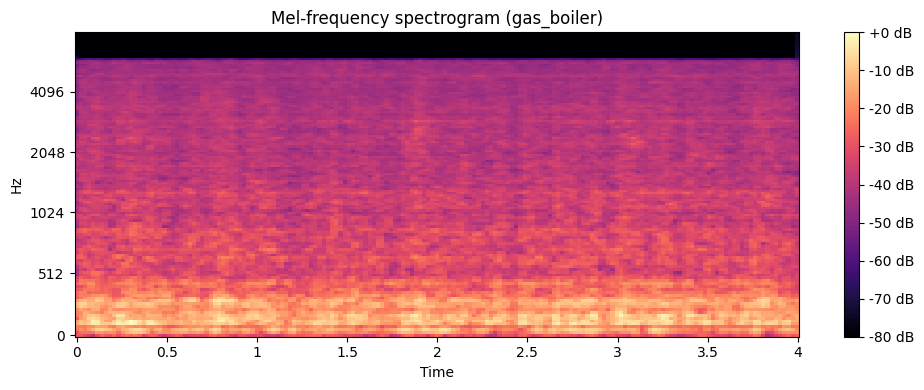

In [23]:
show_sample(samp, title="gas_boiler")

## Train/validation split

Split data into training and validation 

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train, val = train_test_split(df, stratify=df.label, random_state=0, test_size=0.17)
train.shape, val.shape

((36, 3), (8, 3))

In [26]:
df['isval'] = [i in val.index for i in df.index]

In [27]:
df[df.isval]

,filepath,label,duration,isval
0,../data/dehumidifier/1000060-11-0-0.wav,dehumidifier,4.0,True
12,../data/dehumidifier/1000084-11-0-0.wav,dehumidifier,4.0,True
15,../data/dehumidifier/1000012-11-0-0.wav,dehumidifier,4.0,True
25,../data/gas_boiler/3000084-12-0-0.wav,gas_boiler,4.0,True
26,../data/gas_boiler/3000144-12-0-0.wav,gas_boiler,4.0,True
33,../data/lesker_system/2000112-10-0-0.wav,lesker_system,4.0,True
37,../data/lesker_system/2000312-10-0-0.wav,lesker_system,4.0,True
38,../data/lesker_system/2000084-10-0-0.wav,lesker_system,4.0,True


In [28]:
train.label.value_counts()

label
dehumidifier     16
lesker_system    12
gas_boiler        8
Name: count, dtype: int64

In [29]:
val.label.value_counts()

label
dehumidifier     3
lesker_system    3
gas_boiler       2
Name: count, dtype: int64

## Import / download pretrained model (speechbrain urbansound)

In [30]:
import torchaudio
from speechbrain.inference.classifiers import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


For fun, I'm just going to run the classifier which is predicting urban sounds, and see what it says on random samples from our new dataset - it's interesting what it predicts! 

In [31]:
sample = get_sample_of("lesker_system")
classifier.classify_file(sample.filepath)

(tensor([[-0.3098, -0.0649,  0.4000, -0.3211, -0.0164, -0.2455,  0.3886,  0.4876,
           0.2476,  0.0081]]),
 tensor([0.4876]),
 tensor([7]),
 ['jackhammer'])

In [32]:
play_sample(sample)

../data/lesker_system/2000012-10-0-0.wav lesker_system


In [33]:
sample = get_sample_of("dehumidifier", random_state=1)
classifier.classify_file(sample.filepath)

(tensor([[-0.6137,  0.2272,  0.2210, -0.0820,  0.2598,  0.0804, -0.1296, -0.0834,
           0.4030, -0.3970]]),
 tensor([0.4030]),
 tensor([8]),
 ['drilling'])

In [34]:
play_sample(sample)

../data/dehumidifier/1000480-11-0-0.wav dehumidifier


## Convert audio to tensors for training 

In [35]:
import torchaudio
import torch

different samples have different length tensor (longer or shorter time series) 

In [36]:
sample = get_sample_of("dehumidifier")
tens, size = torchaudio.load(sample.filepath)
tens.shape, size

(torch.Size([1, 64000]), 16000)

the classifier's `load_audio` function does some extra stuff like normalization, so let's use that 


In [37]:
tens = classifier.load_audio(sample.filepath)
tens.shape

torch.Size([64000])

In [38]:
tens.unsqueeze(0).shape

torch.Size([1, 64000])

In [39]:
rel_length =  torch.tensor([1.])
enc = classifier.encode_batch(tens.unsqueeze(0), rel_length)
enc.shape

torch.Size([1, 1, 192])

In [40]:
# probabilities of each class
preds = classifier.mods.classifier(enc).squeeze(1); preds

tensor([[-0.2904, -0.2968,  0.4438, -0.3676, -0.0151, -0.1992,  0.4091,  0.3782,
          0.2536, -0.1339]])

In [41]:
# batch of preds, but just 1 in the batch 
preds.shape

torch.Size([1, 10])

In [42]:
# check that our work agrees with the full implementation 
classifier.classify_file(sample.filepath)

(tensor([[-0.2904, -0.2968,  0.4438, -0.3676, -0.0151, -0.1992,  0.4091,  0.3782,
           0.2536, -0.1339]]),
 tensor([0.4438]),
 tensor([2]),
 ['air_conditioner'])

## Create dataset 

In [43]:
from torch.utils.data import Dataset
import torch.nn.functional as F

In [44]:
cats

['dehumidifier', 'gas_boiler', 'lesker_system']

In [47]:
train.head(3)

,filepath,label,duration
21,../data/gas_boiler/3000004-12-0-0.wav,gas_boiler,4.0
42,../data/lesker_system/2000060-10-0-0.wav,lesker_system,4.0
40,../data/lesker_system/2000420-10-0-0.wav,lesker_system,4.0


In [48]:
val.head(3)

,filepath,label,duration
25,../data/gas_boiler/3000084-12-0-0.wav,gas_boiler,4.0
15,../data/dehumidifier/1000012-11-0-0.wav,dehumidifier,4.0
33,../data/lesker_system/2000112-10-0-0.wav,lesker_system,4.0


In [165]:
from functools import cache

class ApplianceDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 
    def __len__(self): return len(self.y)
    
    @cache
    def __getitem__(self, i):
        y = torch.zeros(3)
        y[cats.index(self.y[i])] = 1.
        return self.X[i], y

In [166]:
Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
Xval = torch.stack([classifier.load_audio(fp) for fp in val.filepath])
ytrain = list(train.label)
yval = list(val.label)
Xtrain.shape, Xval.shape

(torch.Size([36, 64000]), torch.Size([8, 64000]))

In [167]:
train_ds = ApplianceDS(Xtrain, ytrain)
val_ds = ApplianceDS(Xval, yval)

In [168]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
# we don't need batches for the validation set so just put into a big batch 
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

In [169]:
Xval, yval = next(iter(val_dl))

In [170]:
Xval.shape, yval.shape

(torch.Size([8, 64000]), torch.Size([8, 3]))

In [172]:
def reset_weights():
    classifier.mods.classifier.weight = torch.nn.Parameter(torch.FloatTensor(3, 192))
    torch.nn.init.xavier_uniform_(classifier.mods.classifier.weight)
reset_weights()

In [173]:
for param in classifier.mods.classifier.parameters():
    print(param.requires_grad)

True


In [174]:
classifier.mods.compute_features

Fbank(
  (compute_STFT): STFT()
  (compute_fbanks): Filterbank()
  (compute_deltas): Deltas()
  (context_window): ContextWindow()
)

In [175]:
for mod in classifier.mods:
    print(mod)
    for p in classifier.mods.__getattr__(mod).parameters():
        print(mod, p.requires_grad)
        break

compute_features
mean_var_norm
embedding_model
embedding_model False
classifier
classifier True


In [176]:
loss_fn = torch.nn.CrossEntropyLoss()

In [208]:
train_loss = []
val_loss = []
reset_weights()
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.001)
for epoch in tqdm(range(100)):
    losses = []
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    val_preds, *_ = classifier(Xval)    
    val_loss_ = loss_fn(val_preds, yval)
    val_loss.append(val_loss_.item())

    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

  1%|█                                                                                                         | 1/100 [00:01<02:52,  1.75s/it]

Epoch 0: Train Loss: 1.0799, Validation Loss: 1.0964


  2%|██                                                                                                        | 2/100 [00:03<02:56,  1.80s/it]

Epoch 1: Train Loss: 1.0690, Validation Loss: 1.0914


  3%|███▏                                                                                                      | 3/100 [00:05<02:55,  1.81s/it]

Epoch 2: Train Loss: 1.0824, Validation Loss: 1.0862


  4%|████▏                                                                                                     | 4/100 [00:07<02:54,  1.82s/it]

Epoch 3: Train Loss: 1.0643, Validation Loss: 1.0809


  5%|█████▎                                                                                                    | 5/100 [00:09<02:52,  1.81s/it]

Epoch 4: Train Loss: 1.0613, Validation Loss: 1.0768


  6%|██████▎                                                                                                   | 6/100 [00:10<02:51,  1.82s/it]

Epoch 5: Train Loss: 1.0524, Validation Loss: 1.0720


  7%|███████▍                                                                                                  | 7/100 [00:12<02:49,  1.82s/it]

Epoch 6: Train Loss: 1.0415, Validation Loss: 1.0673


  8%|████████▍                                                                                                 | 8/100 [00:14<02:47,  1.82s/it]

Epoch 7: Train Loss: 1.0372, Validation Loss: 1.0630


  9%|█████████▌                                                                                                | 9/100 [00:16<02:44,  1.81s/it]

Epoch 8: Train Loss: 1.0361, Validation Loss: 1.0588


 10%|██████████▌                                                                                              | 10/100 [00:18<02:44,  1.82s/it]

Epoch 9: Train Loss: 1.0361, Validation Loss: 1.0550


 11%|███████████▌                                                                                             | 11/100 [00:19<02:41,  1.81s/it]

Epoch 10: Train Loss: 1.0225, Validation Loss: 1.0512


 12%|████████████▌                                                                                            | 12/100 [00:21<02:38,  1.80s/it]

Epoch 11: Train Loss: 1.0227, Validation Loss: 1.0475


 13%|█████████████▋                                                                                           | 13/100 [00:23<02:36,  1.80s/it]

Epoch 12: Train Loss: 1.0233, Validation Loss: 1.0438


 14%|██████████████▋                                                                                          | 14/100 [00:25<02:35,  1.80s/it]

Epoch 13: Train Loss: 1.0171, Validation Loss: 1.0403


 15%|███████████████▊                                                                                         | 15/100 [00:27<02:34,  1.82s/it]

Epoch 14: Train Loss: 1.0239, Validation Loss: 1.0370


 16%|████████████████▊                                                                                        | 16/100 [00:29<02:33,  1.83s/it]

Epoch 15: Train Loss: 1.0053, Validation Loss: 1.0336


 17%|█████████████████▊                                                                                       | 17/100 [00:30<02:31,  1.83s/it]

Epoch 16: Train Loss: 1.0005, Validation Loss: 1.0300


 18%|██████████████████▉                                                                                      | 18/100 [00:32<02:28,  1.81s/it]

Epoch 17: Train Loss: 0.9930, Validation Loss: 1.0268


 19%|███████████████████▉                                                                                     | 19/100 [00:34<02:26,  1.81s/it]

Epoch 18: Train Loss: 0.9948, Validation Loss: 1.0236


 20%|█████████████████████                                                                                    | 20/100 [00:36<02:23,  1.80s/it]

Epoch 19: Train Loss: 0.9820, Validation Loss: 1.0208


 21%|██████████████████████                                                                                   | 21/100 [00:38<02:22,  1.80s/it]

Epoch 20: Train Loss: 0.9934, Validation Loss: 1.0180


 22%|███████████████████████                                                                                  | 22/100 [00:39<02:19,  1.79s/it]

Epoch 21: Train Loss: 0.9921, Validation Loss: 1.0152


 23%|████████████████████████▏                                                                                | 23/100 [00:41<02:20,  1.82s/it]

Epoch 22: Train Loss: 0.9741, Validation Loss: 1.0122


 24%|█████████████████████████▏                                                                               | 24/100 [00:43<02:18,  1.83s/it]

Epoch 23: Train Loss: 0.9800, Validation Loss: 1.0092


 25%|██████████████████████████▎                                                                              | 25/100 [00:45<02:16,  1.82s/it]

Epoch 24: Train Loss: 0.9666, Validation Loss: 1.0061


 26%|███████████████████████████▎                                                                             | 26/100 [00:47<02:15,  1.83s/it]

Epoch 25: Train Loss: 0.9556, Validation Loss: 1.0036


 27%|████████████████████████████▎                                                                            | 27/100 [00:49<02:13,  1.83s/it]

Epoch 26: Train Loss: 0.9707, Validation Loss: 1.0015


 28%|█████████████████████████████▍                                                                           | 28/100 [00:50<02:11,  1.83s/it]

Epoch 27: Train Loss: 0.9729, Validation Loss: 0.9995


 29%|██████████████████████████████▍                                                                          | 29/100 [00:52<02:09,  1.82s/it]

Epoch 28: Train Loss: 0.9636, Validation Loss: 0.9976


 30%|███████████████████████████████▌                                                                         | 30/100 [00:54<02:07,  1.81s/it]

Epoch 29: Train Loss: 0.9613, Validation Loss: 0.9950


 31%|████████████████████████████████▌                                                                        | 31/100 [00:56<02:05,  1.82s/it]

Epoch 30: Train Loss: 0.9544, Validation Loss: 0.9925


 32%|█████████████████████████████████▌                                                                       | 32/100 [00:58<02:03,  1.82s/it]

Epoch 31: Train Loss: 0.9568, Validation Loss: 0.9900


 33%|██████████████████████████████████▋                                                                      | 33/100 [00:59<02:01,  1.82s/it]

Epoch 32: Train Loss: 0.9634, Validation Loss: 0.9879


 34%|███████████████████████████████████▋                                                                     | 34/100 [01:01<02:00,  1.83s/it]

Epoch 33: Train Loss: 0.9496, Validation Loss: 0.9853


 35%|████████████████████████████████████▊                                                                    | 35/100 [01:03<01:59,  1.84s/it]

Epoch 34: Train Loss: 0.9429, Validation Loss: 0.9833


 36%|█████████████████████████████████████▊                                                                   | 36/100 [01:05<01:58,  1.85s/it]

Epoch 35: Train Loss: 0.9408, Validation Loss: 0.9814


 37%|██████████████████████████████████████▊                                                                  | 37/100 [01:07<01:56,  1.84s/it]

Epoch 36: Train Loss: 0.9459, Validation Loss: 0.9794


 38%|███████████████████████████████████████▉                                                                 | 38/100 [01:09<01:54,  1.84s/it]

Epoch 37: Train Loss: 0.9464, Validation Loss: 0.9773


 39%|████████████████████████████████████████▉                                                                | 39/100 [01:10<01:52,  1.84s/it]

Epoch 38: Train Loss: 0.9345, Validation Loss: 0.9754


 40%|██████████████████████████████████████████                                                               | 40/100 [01:12<01:49,  1.82s/it]

Epoch 39: Train Loss: 0.9384, Validation Loss: 0.9737


 41%|███████████████████████████████████████████                                                              | 41/100 [01:14<01:48,  1.83s/it]

Epoch 40: Train Loss: 0.9405, Validation Loss: 0.9718


 42%|████████████████████████████████████████████                                                             | 42/100 [01:16<01:46,  1.84s/it]

Epoch 41: Train Loss: 0.9534, Validation Loss: 0.9700


 43%|█████████████████████████████████████████████▏                                                           | 43/100 [01:18<01:45,  1.85s/it]

Epoch 42: Train Loss: 0.9380, Validation Loss: 0.9680


 44%|██████████████████████████████████████████████▏                                                          | 44/100 [01:20<01:43,  1.85s/it]

Epoch 43: Train Loss: 0.9281, Validation Loss: 0.9663


 45%|███████████████████████████████████████████████▎                                                         | 45/100 [01:22<01:41,  1.85s/it]

Epoch 44: Train Loss: 0.9421, Validation Loss: 0.9648


 46%|████████████████████████████████████████████████▎                                                        | 46/100 [01:23<01:39,  1.85s/it]

Epoch 45: Train Loss: 0.9292, Validation Loss: 0.9632


 47%|█████████████████████████████████████████████████▎                                                       | 47/100 [01:25<01:38,  1.85s/it]

Epoch 46: Train Loss: 0.9204, Validation Loss: 0.9616


 48%|██████████████████████████████████████████████████▍                                                      | 48/100 [01:27<01:35,  1.84s/it]

Epoch 47: Train Loss: 0.9180, Validation Loss: 0.9602


 49%|███████████████████████████████████████████████████▍                                                     | 49/100 [01:29<01:32,  1.81s/it]

Epoch 48: Train Loss: 0.9099, Validation Loss: 0.9588


 50%|████████████████████████████████████████████████████▌                                                    | 50/100 [01:31<01:31,  1.82s/it]

Epoch 49: Train Loss: 0.9130, Validation Loss: 0.9576


 51%|█████████████████████████████████████████████████████▌                                                   | 51/100 [01:32<01:29,  1.82s/it]

Epoch 50: Train Loss: 0.9226, Validation Loss: 0.9565


 52%|██████████████████████████████████████████████████████▌                                                  | 52/100 [01:34<01:27,  1.83s/it]

Epoch 51: Train Loss: 0.9125, Validation Loss: 0.9552


 53%|███████████████████████████████████████████████████████▋                                                 | 53/100 [01:36<01:26,  1.84s/it]

Epoch 52: Train Loss: 0.9089, Validation Loss: 0.9539


 54%|████████████████████████████████████████████████████████▋                                                | 54/100 [01:38<01:24,  1.83s/it]

Epoch 53: Train Loss: 0.9098, Validation Loss: 0.9528


 55%|█████████████████████████████████████████████████████████▊                                               | 55/100 [01:40<01:23,  1.86s/it]

Epoch 54: Train Loss: 0.9118, Validation Loss: 0.9518


 56%|██████████████████████████████████████████████████████████▊                                              | 56/100 [01:42<01:21,  1.86s/it]

Epoch 55: Train Loss: 0.9012, Validation Loss: 0.9508


 57%|███████████████████████████████████████████████████████████▊                                             | 57/100 [01:44<01:20,  1.86s/it]

Epoch 56: Train Loss: 0.9116, Validation Loss: 0.9499


 58%|████████████████████████████████████████████████████████████▉                                            | 58/100 [01:46<01:18,  1.87s/it]

Epoch 57: Train Loss: 0.9152, Validation Loss: 0.9490


 59%|█████████████████████████████████████████████████████████████▉                                           | 59/100 [01:47<01:16,  1.87s/it]

Epoch 58: Train Loss: 0.9099, Validation Loss: 0.9479


 60%|███████████████████████████████████████████████████████████████                                          | 60/100 [01:49<01:14,  1.86s/it]

Epoch 59: Train Loss: 0.9139, Validation Loss: 0.9470


 61%|████████████████████████████████████████████████████████████████                                         | 61/100 [01:51<01:12,  1.85s/it]

Epoch 60: Train Loss: 0.9041, Validation Loss: 0.9460


 62%|█████████████████████████████████████████████████████████████████                                        | 62/100 [01:53<01:10,  1.85s/it]

Epoch 61: Train Loss: 0.9132, Validation Loss: 0.9450


 63%|██████████████████████████████████████████████████████████████████▏                                      | 63/100 [01:55<01:08,  1.84s/it]

Epoch 62: Train Loss: 0.9038, Validation Loss: 0.9441


 64%|███████████████████████████████████████████████████████████████████▏                                     | 64/100 [01:57<01:06,  1.85s/it]

Epoch 63: Train Loss: 0.8990, Validation Loss: 0.9431


 65%|████████████████████████████████████████████████████████████████████▎                                    | 65/100 [01:58<01:04,  1.84s/it]

Epoch 64: Train Loss: 0.9016, Validation Loss: 0.9422


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 66/100 [02:00<01:02,  1.83s/it]

Epoch 65: Train Loss: 0.9068, Validation Loss: 0.9413


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 67/100 [02:02<01:00,  1.84s/it]

Epoch 66: Train Loss: 0.8918, Validation Loss: 0.9402


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 68/100 [02:04<00:58,  1.83s/it]

Epoch 67: Train Loss: 0.9061, Validation Loss: 0.9398


 69%|████████████████████████████████████████████████████████████████████████▍                                | 69/100 [02:06<00:57,  1.85s/it]

Epoch 68: Train Loss: 0.8925, Validation Loss: 0.9390


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 70/100 [02:08<00:55,  1.84s/it]

Epoch 69: Train Loss: 0.8966, Validation Loss: 0.9384


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 71/100 [02:09<00:53,  1.83s/it]

Epoch 70: Train Loss: 0.8931, Validation Loss: 0.9380


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 72/100 [02:11<00:51,  1.82s/it]

Epoch 71: Train Loss: 0.9004, Validation Loss: 0.9374


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 73/100 [02:13<00:49,  1.83s/it]

Epoch 72: Train Loss: 0.9063, Validation Loss: 0.9369


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 74/100 [02:15<00:48,  1.85s/it]

Epoch 73: Train Loss: 0.8990, Validation Loss: 0.9363


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 75/100 [02:17<00:46,  1.86s/it]

Epoch 74: Train Loss: 0.8830, Validation Loss: 0.9355


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 76/100 [02:19<00:44,  1.85s/it]

Epoch 75: Train Loss: 0.9033, Validation Loss: 0.9353


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 77/100 [02:21<00:42,  1.85s/it]

Epoch 76: Train Loss: 0.8823, Validation Loss: 0.9347


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 78/100 [02:22<00:40,  1.83s/it]

Epoch 77: Train Loss: 0.8884, Validation Loss: 0.9346


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 79/100 [02:24<00:38,  1.83s/it]

Epoch 78: Train Loss: 0.8964, Validation Loss: 0.9343


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 80/100 [02:26<00:36,  1.84s/it]

Epoch 79: Train Loss: 0.8929, Validation Loss: 0.9337


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 81/100 [02:28<00:34,  1.83s/it]

Epoch 80: Train Loss: 0.8942, Validation Loss: 0.9331


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 82/100 [02:30<00:32,  1.82s/it]

Epoch 81: Train Loss: 0.8770, Validation Loss: 0.9329


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 83/100 [02:31<00:30,  1.82s/it]

Epoch 82: Train Loss: 0.8916, Validation Loss: 0.9330


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 84/100 [02:33<00:29,  1.82s/it]

Epoch 83: Train Loss: 0.8835, Validation Loss: 0.9325


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 85/100 [02:35<00:27,  1.81s/it]

Epoch 84: Train Loss: 0.8797, Validation Loss: 0.9321


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 86/100 [02:37<00:25,  1.82s/it]

Epoch 85: Train Loss: 0.8781, Validation Loss: 0.9321


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 87/100 [02:39<00:23,  1.82s/it]

Epoch 86: Train Loss: 0.8892, Validation Loss: 0.9318


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 88/100 [02:41<00:21,  1.83s/it]

Epoch 87: Train Loss: 0.8787, Validation Loss: 0.9314


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 89/100 [02:42<00:20,  1.83s/it]

Epoch 88: Train Loss: 0.8902, Validation Loss: 0.9310


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [02:44<00:18,  1.84s/it]

Epoch 89: Train Loss: 0.8857, Validation Loss: 0.9306


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 91/100 [02:46<00:16,  1.84s/it]

Epoch 90: Train Loss: 0.8946, Validation Loss: 0.9302


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 92/100 [02:48<00:14,  1.86s/it]

Epoch 91: Train Loss: 0.8874, Validation Loss: 0.9297


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [02:50<00:12,  1.85s/it]

Epoch 92: Train Loss: 0.8919, Validation Loss: 0.9291


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 94/100 [02:52<00:10,  1.83s/it]

Epoch 93: Train Loss: 0.9025, Validation Loss: 0.9284


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [02:53<00:09,  1.82s/it]

Epoch 94: Train Loss: 0.8844, Validation Loss: 0.9277


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [02:55<00:07,  1.82s/it]

Epoch 95: Train Loss: 0.8723, Validation Loss: 0.9272


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [02:57<00:05,  1.83s/it]

Epoch 96: Train Loss: 0.8975, Validation Loss: 0.9270


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [02:59<00:03,  1.82s/it]

Epoch 97: Train Loss: 0.8855, Validation Loss: 0.9266


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [03:01<00:01,  1.82s/it]

Epoch 98: Train Loss: 0.8942, Validation Loss: 0.9263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]

Epoch 99: Train Loss: 0.8825, Validation Loss: 0.9258


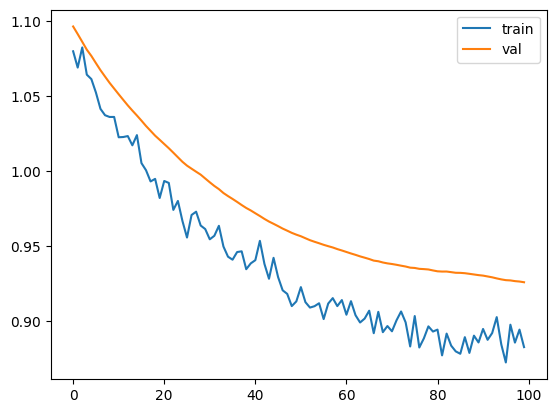

In [209]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train','val'])
plt.show();

### Validation accuracy 

In [226]:
cats

['dehumidifier', 'gas_boiler', 'lesker_system']

In [214]:
preds, *rest = classifier(Xval)

In [215]:
preds.argmax(axis=1)

tensor([0, 2, 2, 0, 0, 0, 2, 0])

In [216]:
yval.argmax(axis=1)

tensor([0, 2, 2, 1, 1, 0, 2, 0])

In [217]:
(preds.argmax(axis=1) == yval.argmax(axis=1)).float().mean()

tensor(0.7500)

### Train accuracy 

In [221]:
torch.tensor([cats.index(val) for val in ytrain])

tensor([1, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1,
        1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 2])

In [224]:
train_preds, *rest = classifier(Xtrain)
train_preds.argmax(axis=1)

tensor([1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [227]:
(torch.tensor([cats.index(val) for val in ytrain]) == train_preds.argmax(axis=1)).float().mean()

tensor(0.6944)